In [1]:
#Importing Packages
import Classifier
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler

sampler=RandomUnderSampler()




from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,roc_auc_score



import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px

In [2]:
#Defining the data sample of 0.01% of entire data
data=pd.read_parquet('/home/hashmi/Files/DataFolder/UpgradeSeedClassifier-Origin/InitialAnalysis/data/true_no_hits_15114101.parquet')[
    ['track_chi2PerDoF','track_nLHCbIDs','track_p',
     'track_phi','track_position_x', 'track_position_y',
     'track_position_r','track_tx', 'track_ty',
     'track_pseudoRapidity','particle_isDown_noVelo']].head(5000)

In [3]:
#Defining Dependent and Independent Variables, Splitting the data
x=data.drop('particle_isDown_noVelo',axis=1)
y=data['particle_isDown_noVelo']
x,y=sampler.fit_resample(x,y)

x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y,random_state=6)

train_data=pd.concat([x_train,y_train],axis=1)
test_data=pd.concat([x_test,y_test],axis=1)

In [4]:
%%time
train_data['ModelOutput_Value'] = [Classifier.apply_catboost_model(values) for values in x_train.values]
train_data['ModelOutput_Class'] = [False if output_value<0 else True for output_value in train_data['ModelOutput_Value']]
test_data['ModelOutput_Value'] = [Classifier.apply_catboost_model(values) for values in x_test.values]
test_data['ModelOutput_Class'] = [False if output_value<0 else True for output_value in test_data['ModelOutput_Value']]
data['ModelOutput_Value'] = [Classifier.apply_catboost_model(values) for values in data.values]
data['ModelOutput_Class'] = [False if output_value<0 else True for output_value in data['ModelOutput_Value']]

CPU times: user 24.1 s, sys: 0 ns, total: 24.1 s
Wall time: 24.1 s


In [5]:
#TrainData Accuracy and Checking the nature of the datapoints correctly predicted

print('Train Data Accuracy is ',train_data.loc[train_data['particle_isDown_noVelo']==train_data['ModelOutput_Class']].shape[0]/train_data.shape[0])
# display(train_data.loc[train_data['particle_isDown_noVelo']==train_data['ModelOutput_Class']])

Train Data Accuracy is  0.6222005842259006


In [6]:
#TestData

print('Test Data Accuracy is ',test_data.loc[test_data['particle_isDown_noVelo']==test_data['ModelOutput_Class']].shape[0]/test_data.shape[0])
# display(test_data.loc[test_data['particle_isDown_noVelo']==test_data['ModelOutput_Class']])

Test Data Accuracy is  0.6268221574344023


### Plots

In [49]:
#Checking the distribution of datapoints with respect to the class it belongs to, histogram on the right shows the 
# over all distribution
px.scatter(train_data,x='ModelOutput_Value',color='particle_isDown_noVelo',marginal_x='histogram')

In [47]:
#Checking the distribution of datapoints with respect to the class it belongs to, histogram on the right shows the 
# over all distribution
px.scatter(data,y='ModelOutput_Value',color='particle_isDown_noVelo',marginal_y='histogram')

In [37]:
#TestData
px.scatter(test_data,y='ModelOutput_Value',color='particle_isDown_noVelo',marginal_y='histogram')

In [38]:
#Model Output statistical value distribution to check the outliers.
px.box(test_data,y='ModelOutput_Value',color='particle_isDown_noVelo')

<__array_function__ internals>:5: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.

<__array_function__ internals>:5: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.

<__array_function__ internals>:5: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.

<__array_function__ internals>:5: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.



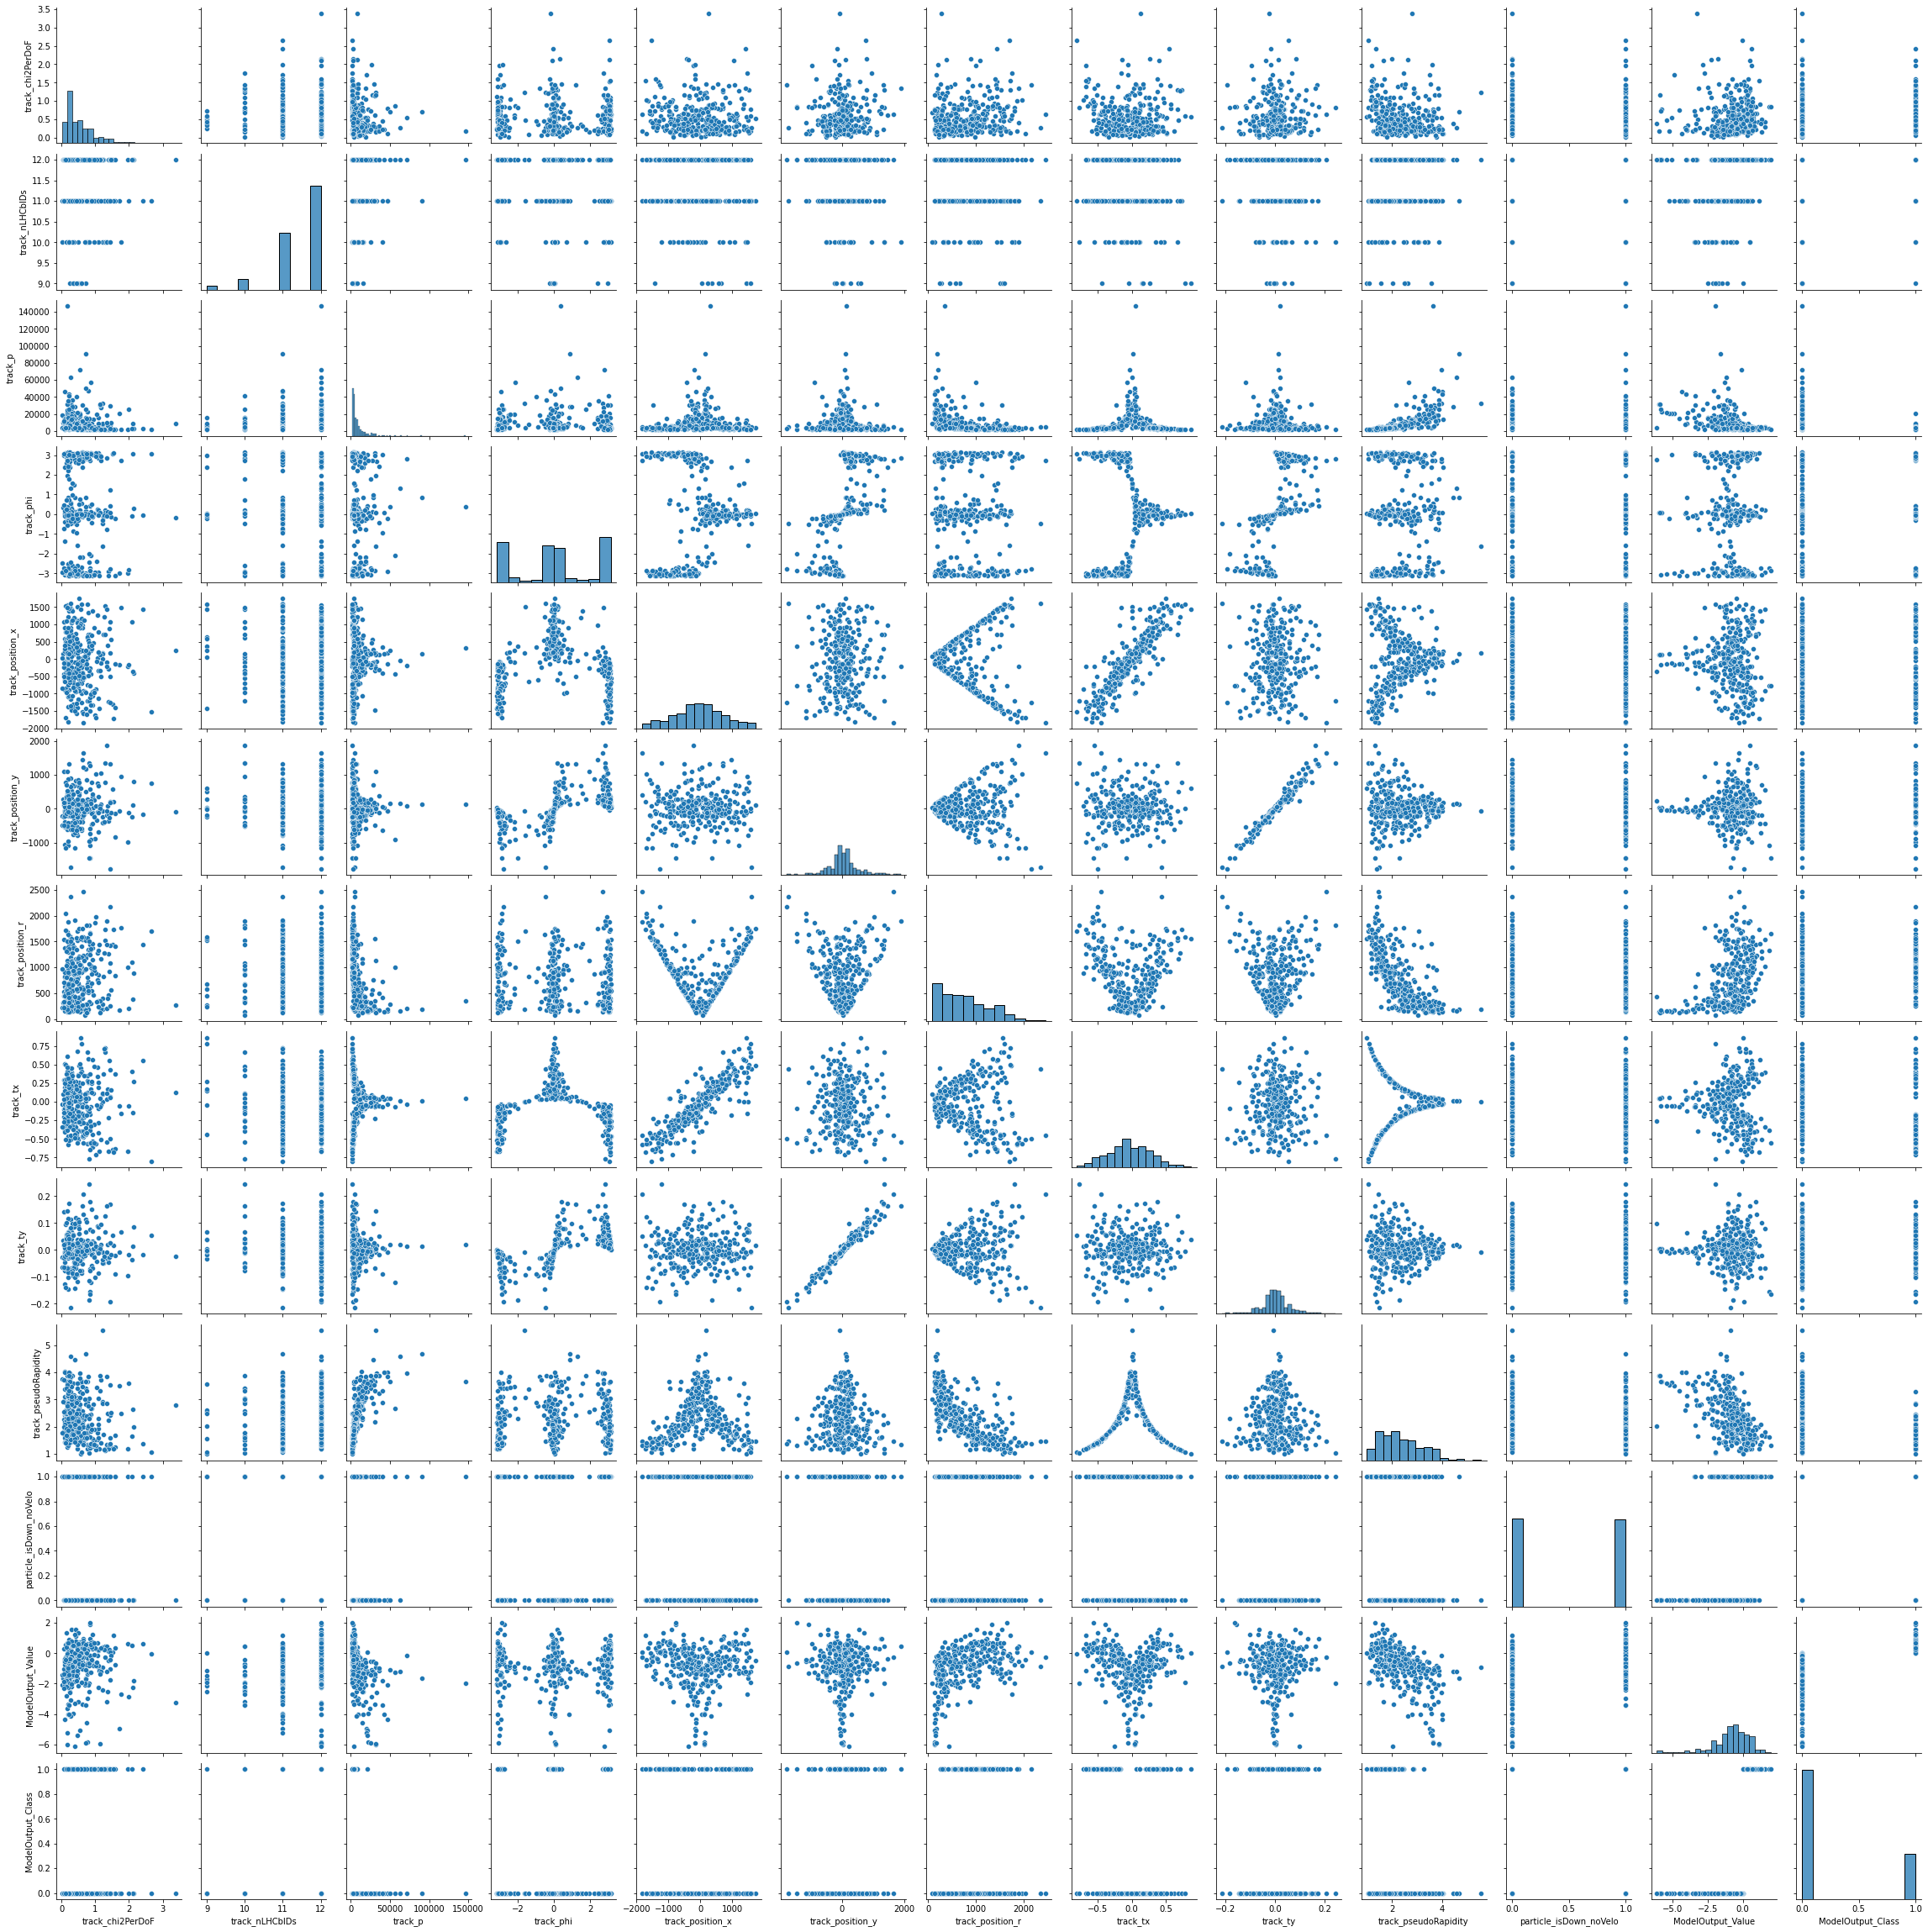

In [39]:
#interdependencies of variables in TestData
sns.pairplot(test_data)
plt.show()

In [40]:
#The plot helps to identify the concentration of values with respect to the region and its number of counts.
fig = px.density_heatmap(test_data, x="ModelOutput_Value", y="particle_isDown_noVelo",nbinsx=1000,nbinsy=1000)
fig.show()

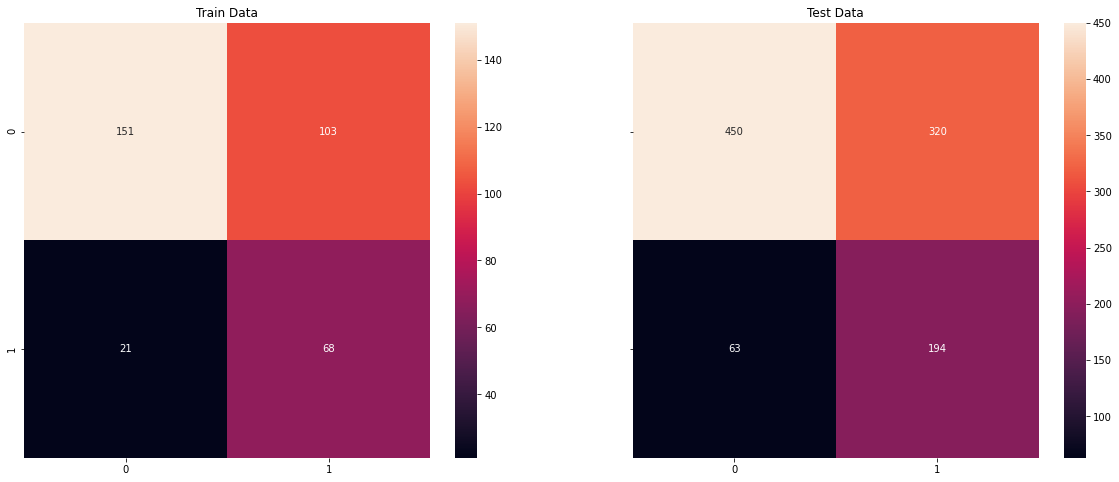

In [41]:
#Confusion Matrix for Test and Train Data - "Imbalance Data Distribution"
fig,ax=plt.subplots(1,2,figsize=(20,8),sharey=True)
sns.heatmap(confusion_matrix(test_data['ModelOutput_Class'],test_data['particle_isDown_noVelo']),fmt='d',annot=True,ax=ax[0])
ax[0].set_title('Train Data')
sns.heatmap(confusion_matrix(train_data['ModelOutput_Class'],train_data['particle_isDown_noVelo']),fmt='d',annot=True,ax=ax[1])
ax[1].set_title('Test Data')
plt.show()

In [42]:
f1_score(test_data['ModelOutput_Class'],test_data['particle_isDown_noVelo'])

0.5230769230769231

In [43]:
roc_auc_score(test_data['ModelOutput_Class'],test_data['particle_isDown_noVelo'])

0.6792665663983014

In [44]:
test_data.head()

,track_chi2PerDoF,track_nLHCbIDs,track_p,track_phi,track_position_x,track_position_y,track_position_r,track_tx,track_ty,track_pseudoRapidity,particle_isDown_noVelo,ModelOutput_Value,ModelOutput_Class
898,0.233552,12.0,5951.270563,-3.102270,-885.696350,-65.212456,888.093851,-0.251660,-0.009901,2.087544,True,-0.217462,False
1061,0.524639,12.0,8551.321943,2.906260,-307.923676,227.590958,382.902904,-0.130757,0.031352,2.704100,True,-0.106504,False
990,0.526391,12.0,6188.406264,2.969626,-572.663452,281.062256,637.918036,-0.204281,0.035480,2.277125,True,0.254820,True
1034,0.250748,11.0,27221.521360,0.142359,557.808594,30.366793,558.634558,0.046912,0.006724,3.743018,True,-2.093154,False
526,0.252621,9.0,15706.168894,2.403376,52.179737,271.004974,275.982646,-0.042122,0.038324,3.559590,False,-2.531275,False


In [45]:
data.head()

,track_chi2PerDoF,track_nLHCbIDs,track_p,track_phi,track_position_x,track_position_y,track_position_r,track_tx,track_ty,track_pseudoRapidity,particle_isDown_noVelo
0,0.376930,11.0,4923.881506,-3.115572,-601.747070,-41.831402,603.199306,-0.240003,-0.006246,2.134020,False
1,0.906116,12.0,2159.286580,-0.006293,1144.674805,-47.993053,1145.680471,0.567381,-0.003570,1.332058,False
2,1.259766,11.0,1953.560581,-0.024234,1496.419067,-234.441742,1514.672557,0.713972,-0.017306,1.138100,False
3,0.726032,11.0,3825.724500,3.122918,-572.315918,89.433388,579.261462,-0.283618,0.005297,1.972634,True
4,0.525203,12.0,1799.832644,0.115020,1059.369507,692.064819,1265.392218,0.668115,0.077188,1.187451,True
